In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate, signal
from scipy.integrate import odeint
import harold
from control import *
import torch
from ilqr_pendulum import *

os.chdir("../")

from helper_fn import *
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
val_data = torch.tensor(np.load("data/pendulum_val.npy")).float()
denis = torch.load("logs/denis_pendulum/model-denis-pend-best.pt", map_location=torch.device('cpu'))
lren = torch.load("logs/lren_pendulum/model-lren-pend-best.pt", map_location=torch.device('cpu'))

enc_gt_de, enc_traj_de, ko_all = denis(val_data)
enc_gt_lr, enc_traj_lr = lren(val_data)
val_data = val_data.detach().numpy()

In [8]:
def pendulum_de(y, t, K):
    phi, omega = y
    y_tensor = torch.tensor(y, dtype=torch.float32).view((1, 1, 2))
    _, enc_traj, _ = denis(y_tensor)
    latent = enc_traj[0, -1, :].detach().numpy()
    u = K.dot(latent)[0, 0]
    t_u_de.append(t)
    de_u.append(u)
    dydt = [omega, -np.sin(phi) - u]
    return dydt

def pendulum_lr(y, t, K):
    phi, omega = y
    y_tensor = torch.tensor(y, dtype=torch.float32).view((1, 1, 2))
    _, enc_traj = lren(y_tensor)
    latent = enc_traj[0, -1, :].detach().numpy()
    u = K.dot(latent)[0, 0]
    t_u_lr.append(t)
    lr_u.append(u)
    dydt = [omega, -np.sin(phi) - u]
    return dydt

In [14]:
def run_sim(idx):
    init = val_data[idx, 0, :]
    print("Random Initial: {}".format(init))
    
    # get initial encodings
    enc_init_de = enc_traj_de[idx, 0, :].detach().numpy()
    enc_init_lr = enc_traj_lr[idx, 0, :].detach().numpy()

    # get koopman operators
    ko = ko_all[idx].detach().numpy()
    ko_lren = list(lren.parameters())[-1].detach().numpy()

    pred_de = [enc_init_de]
    pred_lr = [enc_init_lr]
    n_steps = 500

    for i in range(n_steps):
        pred_de.append(np.matmul(pred_de[-1], ko))
        pred_lr.append(np.matmul(pred_lr[-1], np.transpose(ko_lren)))

    pred_de = np.asarray(pred_de)[:, :2]
    pred_lr = np.asarray(pred_lr)[:, :2]

    t = np.arange(0, n_steps*0.1+0.1, 0.1)
    
    A_de = np.transpose(ko.copy())
    A_lr = np.transpose(ko_lren.copy())
    dim = 2

    ldim_de = len(enc_init_de) - dim
    ldim_lr = len(enc_init_lr) - dim

    Ts = 0.1

    B_de = np.append([0, 1], np.zeros((1, ldim_de)))[:, np.newaxis]
    B_lr = np.append([0, 1], np.zeros((1, ldim_lr)))[:, np.newaxis]

    C_de = np.append([1, 1], np.zeros((1, ldim_de)))
    C_lr = np.append([1, 1], np.zeros((1, ldim_lr)))

    #dsys_de = signal.StateSpace(A_de, B_de, C_de, .0, dt=Ts)
    #dsys_lr = signal.StateSpace(A_lr, B_lr, C_lr, .0, dt=Ts)

    G_de = harold.State(A_de, B_de, C_de, .0, dt=Ts)
    G_lr = harold.State(A_lr, B_lr, C_lr, .0, dt=Ts)

    sys_de = harold.undiscretize(G_de, 'tustin')
    sys_lr = harold.undiscretize(G_lr, 'tustin')

    As_de = sys_de.a
    As_lr = sys_lr.a
    
    Q_de = np.zeros((A_de.shape));
    Q_de[0,0] = 1;
    Q_de[1,1] = 1;

    Q_lr = np.zeros((A_lr.shape));
    Q_lr[0,0] = 1;
    Q_lr[1,1] = 1;

    B_de = np.append([0, 1], np.zeros((1, ldim_de)))[:, np.newaxis]
    B_lr = np.append([0, 1], np.zeros((1, ldim_lr)))[:, np.newaxis]

    K_de, S_de, E_de = lqr(As_de, B_de, Q_de, 1)

    denis.params['n_shifts'] = 1
    lren.params['n_shifts'] = 1
    K_lr, S_lr, E_lr = lqr(As_lr, B_lr, Q_lr, 1.)
    
    dt = 0.1
    N = 101
    t1 = np.arange(0, dt*(N+1), dt)

    y0 = init.copy()
    de_u = []
    lr_u = []
    t_u_lr = []
    t_u_de = []

    sol_de = odeint(pendulum_de, y0, t1, args=(K_de,))
    sol_lr = odeint(pendulum_lr, y0, t1, args=(K_lr,))
    
    # Initialize pendulum dynamics
    dt = 0.1
    dynamics = ilqr_pend(dt)
    cost = pend_cost()

    N = 101  # Number of time-steps in trajectory.
    x0 = y0.copy()  # Initial state.
    us_init = np.random.uniform(-1, 1, (N, 1)) # Random initial action path.

    ilqr = iLQR(dynamics, cost, N)
    xs, us = ilqr.fit(x0, us_init)
    t = np.arange(0, dt*(N+1), dt)
    
    return xs, sol_de, sol_lr, t    

In [69]:
#3456

xs, sol_de, sol_lr, t = run_sim(70)

Random Initial: [0.007542   0.02434733]


In [62]:
def hamiltonian(val):
    x1, x2 = val
    return x2**2/2 + 9.81 * (1-np.cos(x1))

In [183]:
energies = [hamiltonian(i) for i in val_data[:, 0, :]]

In [67]:
low2high_e = np.argsort(energies)

In [187]:
to_show = low2high_e[np.linspace(0, 5000-2, 16).astype(int)]

Random Initial: [-0.3968316 -1.8962951]
Random Initial: [ 0.30790737 -0.25871044]
Random Initial: [-0.49371964 -0.6786607 ]
Random Initial: [-1.8311784   0.47708386]
Random Initial: [-1.242141  -0.9326909]
Random Initial: [0.7510298  0.11656838]
Random Initial: [-2.2656043   0.05431249]
Random Initial: [ 2.1946468  -0.02305265]
Random Initial: [ 0.03252576 -1.7388539 ]
Random Initial: [-0.44564158 -1.6138763 ]
Random Initial: [-2.311608    0.38698125]
Random Initial: [-1.7341015  -0.60069484]
Random Initial: [-0.1997176 -1.1930271]
Random Initial: [ 0.8705217  -0.06772066]
Random Initial: [ 0.03246766 -0.45242938]
Random Initial: [1.8205522 0.3200167]


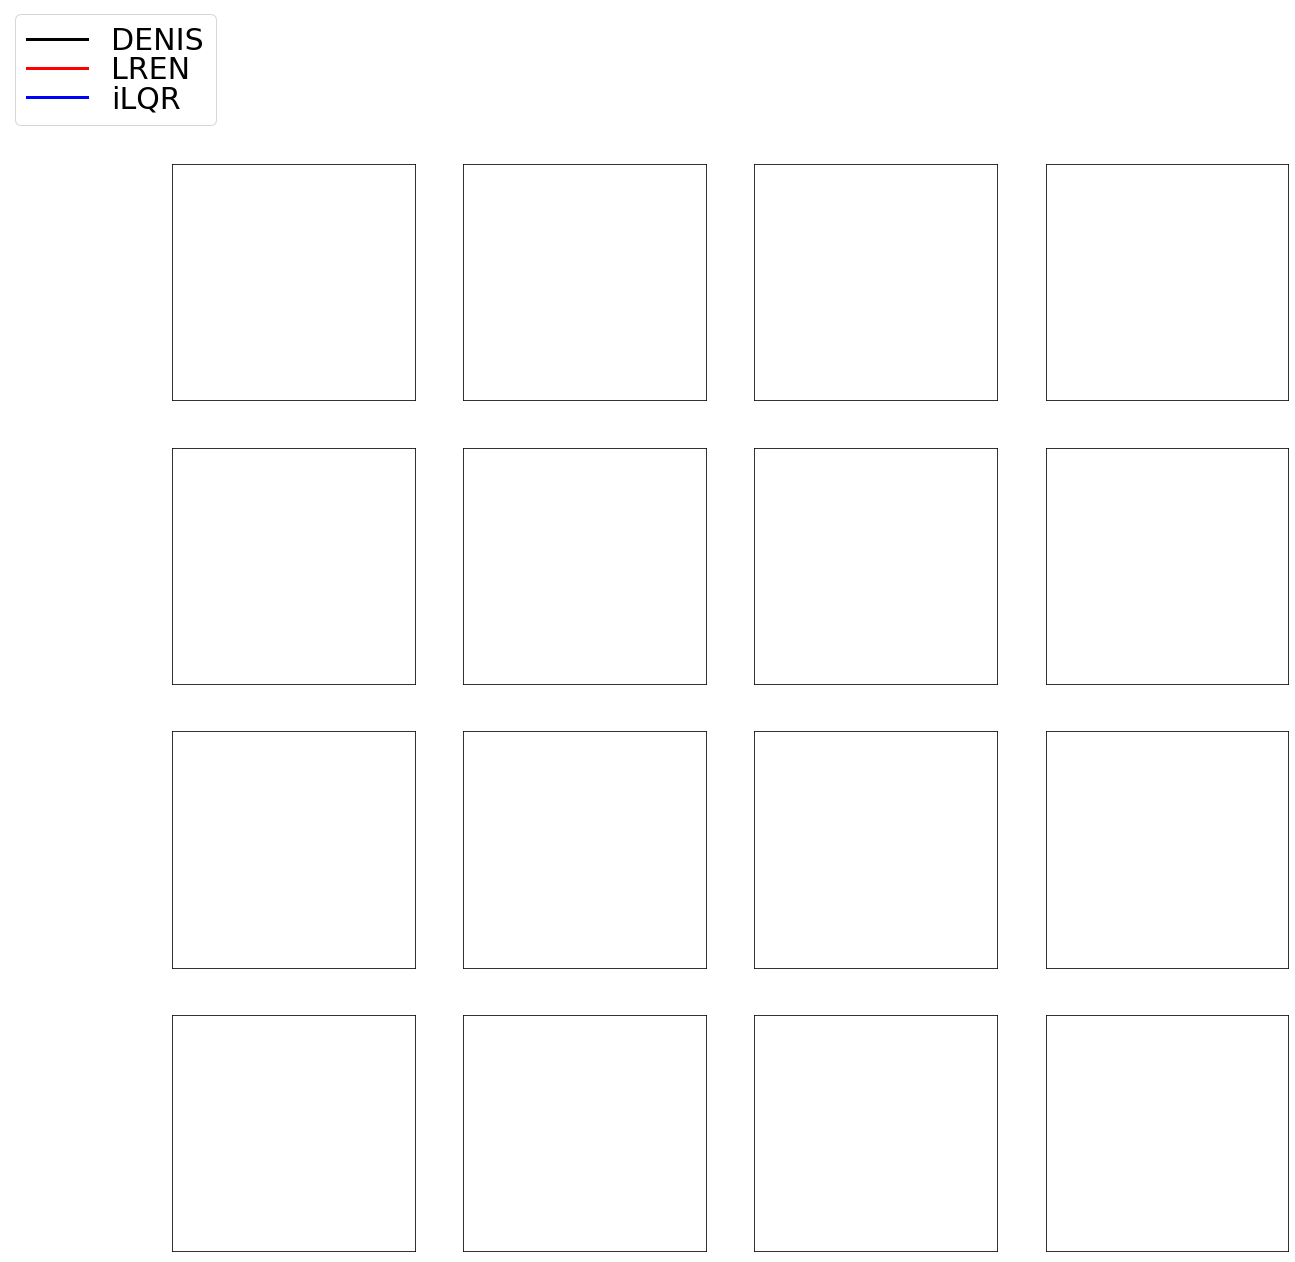

In [190]:
import matplotlib.animation as animation
#fig = plt.figure(figsize=(8, 8), facecolor='w')
#ax = fig.add_subplot(1, 1, 1)
fig, ax = plt.subplots(4, 4, figsize=(20, 20), facecolor='w')
plt.rcParams['font.size'] = 15

for i in range(4):
    for j in range(4):
        ax[i, j].set_xlim([-1, 1])
        ax[i, j].set_ylim([-2, 2])
        ax[i, j].set_yticks([])
        ax[i, j].set_xticks([])
        
lines = []
lns = [[] for i in range(102)]
for i in range(4):
    for j in range(4):
        idx = j+i*4
        xs, sol_de, sol_lr, t = run_sim(idx)
        for k, ti in enumerate(range(len(sol_de))):
            ln, = ax[i, j].plot([0, np.sin(sol_de[ti, 0])], [0, -np.cos(sol_de[ti, 0])],
                          color='k', lw=3)

            ln1, = ax[i, j].plot([0, np.sin(sol_lr[ti, 0])], [0, -np.cos(sol_lr[ti, 0])],
                          color='r', lw=3)

            ln2, = ax[i, j].plot([0, np.sin(xs[ti, 0])], [0, -np.cos(xs[ti, 0])],
                          color='b', lw=3)

            lns[k].append(ln)
            lns[k].append(ln1)
            lns[k].append(ln2)
            
            if idx==15:
                lines.append(ln)
                lines.append(ln1)
                lines.append(ln2)
        ax[i, j].set_aspect('equal', 'datalim')
#ax.legend()
labels=['DENIS', 'LREN', 'iLQR']
plt.figlegend(lines, labels, loc = 'upper left', labelspacing=0. , fontsize=30)


interval=50
ani = animation.ArtistAnimation(fig, lns, interval=interval, repeat=True)
fn = 'figures/pendulum_controlled_ilqr_all'
ani.save(fn+'.mp4',writer='ffmpeg')

In [164]:
len(lns[0])

612

In [158]:
lns = [[] for i in range(12)]


In [160]:
lns[0].append(12)

In [161]:
lns

[[12], [], [], [], [], [], [], [], [], [], [], []]